In [1]:
%load_ext autoreload
%autoreload 2

#### 1. Set up the reaction graph from DFT data 

In [2]:
from arcs.generate import GraphGenerator

graph = GraphGenerator().from_file(
    filename='../app/data/dft_data.json',
    temperature=248,
    pressure=20,
    max_reaction_length=5
)

/Users/badw/github-projects/arcs/src/arcs/generate.py:255: RuntimeWarning: overflow encountered in exp
  K = np.exp(


#### 2. Sample the `graph`

In [3]:
from arcs.traversal import Traversal
from arcs.generate import GenerateInitialConcentrations

gic = GenerateInitialConcentrations(graph=graph).update_ic(
    {'H2O':30,'O2':10,'SO2':10,'H2S':10,'NO2':10}
    #{'H2O':30,'O2':10,'SO2':10,'H2S':10,'NO2':10}
    #{'H2O':30,'SO2':10}
    )

t = Traversal(graph=graph)

data = t.sample(initial_concentrations=gic,ncpus=4,nsamples=1000)

/Users/badw/miniconda3/envs/test/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
1008it [00:49, 20.36it/s]                         


#### 3. generate reaction statistics

In [4]:
from arcs.analysis import AnalyseSampling
import pandas as pd 

analysis = AnalyseSampling()
stats = pd.Series(analysis.reaction_statistics(data)).sort_values(ascending=False)
stats.head(10)

1 H2 + 1 SO2 = 1 O2 + 1 H2S               321
1 H2O + 1 SO2 = 1 H2SO3                   292
3 H2 + 1 SO2 = 2 H2O + 1 H2S              215
2 H2 + 1 O2 = 2 H2O                       205
3 O2 + 2 H2S = 2 H2O + 2 SO2              168
1 H2O + 1 NO2 + 1 NO = 2 HNO2             100
1 H2 + 1 SO2 + 1 NO2 = 1 H2SO3 + 1 NO      87
1 H2 + 1 H2SO4 = 2 H2O + 1 SO2             78
1 H2 + 1 NO2 = 1 H2O + 1 NO                68
1 H2O + 1 SO2 + 1 NO2 = 1 H2SO4 + 1 NO     68
dtype: int64

#### 4. generate mean concentrations and differences

In [5]:
average_data = analysis.average_sampling(data)
average_data = average_data.loc[~(average_data==0).all(axis=1)]
average_data.round(5)
average_data.sort_values(by='diff',inplace=True)
average_data.round(2)

,initial,mean,diff,std,var
H2S,10.0,4.62,-5.38,4.74,22.47
O2,10.0,6.02,-3.98,5.53,30.56
NO2,10.0,6.10,-3.90,4.87,23.73
H2O,30.0,29.81,-0.19,6.08,36.96
NH3,0.0,0.04,0.04,0.48,0.23
S8,0.0,0.09,0.09,0.30,0.09
NOHSO4,0.0,0.12,0.12,0.76,0.57
H2SO3,0.0,0.31,0.31,1.73,2.98
HNO3,0.0,0.52,0.52,1.57,2.46
HNO2,0.0,0.57,0.57,1.92,3.69


#### 5. Plot 

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymatgen-analysis-diffusion 2024.7.15 requires numpy<2.0,>=1.25.0, but you have numpy 2.2.5 which is incompatible.


<Axes: >

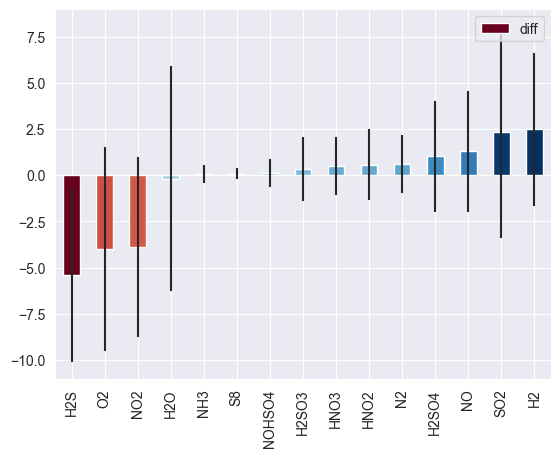

In [ ]:
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
sns.set_style('darkgrid')
sns.set_palette('pastel')


norm = colors.Normalize(vmin=average_data['diff'].min(), vmax=average_data['diff'].max())
cmap = cm.RdBu  # or any other colormap

bar_colors = [cmap(norm(value)) for value in average_data['diff']]

average_data.plot.bar(y='diff',yerr='std',color=bar_colors)

#### 5. generate a `pyvis` graph 

In [ ]:
g = analysis.result_to_pyvis(data,head=10,filename='example_pyvis_graph.html')